# Homework 2
## Jules BAUDET

In [468]:
using Plots


## Mc-Call Job Search Model with Separation

We consider here a very simple job-search model, with separation. Our goal consists in solving this model using a policy iteration algorithm. Some background on the McCall and numerical ideas are discussed on the [QuantEcon](`https://julia.quantecon.org/mccall_model.html`) website.

There is a single worker who can be either employed ("e") or unemployed ("u") in any period.

When unemployed, the jobless worker receives unemployment benefits $c_t=\alpha>0$ in every period as long as he stays unemployed. He also receives a salary offer $w_t$ which is drawn from a discrete i.i.d. distribution and takes values $w_1, ..., w_K$ with probabilities $p_1, ... p_K$ respectively.

When an unemployed worker accepts an offer in period $t$, he gets the salary $w_t$ and becomes employed. He then keeps his salary $w_t$ as long as he stays employed (for $s\geq t$, $c_s=w_t$ if $t$ is the date at which worker got the current job); in each period he has a probability $\lambda$ of becoming unemployed in the next period and remains employed otherwise.

When a worker receives a given amount $x$ his perceived utility is $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma<1.0$. A worker discounts the future at a rate $\beta \in [0,1[$. As a result, in any period $t_0$ workers seek to maximize $\sum_{t\geq t_0}^{\infty} U(c_t)$.


__Define a parameter type `Parameter`, with fields $\alpha$, $\beta$, $\gamma$, $K$, $\sigma$, $\lambda$. Create a parameter variable $\omega$ with $\alpha=0.5$, $\beta=0.96$, $\gamma=4$, $K=10$, $\sigma=0.6$, $\lambda=0.015$__

In [469]:
struct Parameter
    alpha::Float64
    beta::Float64
    gamma::Float64
    K::Int
    sig::Float64
    lam::Float64
end

par = Parameter(0.5, 0.96, 4., 10, 0.6, 0.015)

Parameter(0.5, 0.96, 4.0, 10, 0.6, 0.015)

__What is the uniform distribution, whose mean is 1 and standard deviation is $\sigma$? Write a function `discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64} Vector{Float64}}` to discretize it, using $K$ points. The function should return two vectors `w` and `p` of floats of the same size `K`. Check the results satisfy the right conditions (uniformity, standard deviation).__

In [470]:
function discrete_uniform(sig::Float64, K::Int64)
    w = collect(LinRange(1 - sqrt(3)*sig, 1 + sqrt(3)*sig, K))
    p = [1/K for i = 1:K]
    return w, p 
end

discrete_uniform (generic function with 1 method)

In [471]:
using LinearAlgebra
w,p = discrete_uniform(par.sig,par.K)

mean = dot(w,p)
std = sqrt(dot((w-ones(par.K)).^2, p))

println("mean: ", mean)
println("standard deviation: ",std)

mean: 0.9999999999999998
standard deviation: 0.6633249580710798



The optimal decision of a worker is characterized by two value functions: $V^E(w)$ is the value of being employed at wage $w$ and $V^U(w)$ the value of being unemployed, while receiving job offer $w_t$. In Julia, both $V^U$ and $V^E$ will be represented by arrays `V_U` and `V_E` of size `K`.

A policy `g(w)` is a binary choice in the unemployed state: accept or reject an offer $w_t$. It will then naturally be represented by a boolean array (type `zeros(Bool, K)` to initialize one).

__Given a policy $g$, write down the recursive equations which defines the corresponding value functions $V^{U,g}(w)$ and $V^{E,g}(w)$.__

$$
V^g(w) = V_E(w)g(w) + (1-g(w)) V_U(w)
$$

Where:
$$
V^{E}_{t}(w) = U(w) +\beta \left( \lambda V_{t+1}^U(w) + (1-\lambda)V_{t+1}^E(w)\right) 
$$

$$
V^{U}_{t}(w) = U(\alpha)+\beta \mathbb{E}\left[ \max(V_{t+1}^U(w),V_{t+1}^E(w)) \right] 
$$



__Write a function which takes a guess $V^{U,g}(w)$ and $V^{E,g}(w)$ and a policy function $g$ as arguments (and other model parameters) and updates the values, according to the updating equations. This function could have signature `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})::Vector{Float64}` where the returned vector has the same size as the supplied ones.__

In [472]:
function value_update(V_E::Vector{Float64}, V_U::Vector{Float64}, g::Vector{Bool}, par::Parameter, w::Vector{Float64}, p::Vector{Float64})
    
    V_E2 = w.^(1-par.gamma)/(1-par.gamma) .+ par.beta*(par.lam .* V_U + (1-par.lam).*V_E)
    V_U2 = par.alpha^(1-par.gamma)/(1-par.gamma) .+ par.beta.* ones(length(V_U)).* (dot(max.(V_U,V_E),p))
 
    V_new = (V_E2, V_U2)
    return V_new
end

value_update (generic function with 1 method)


__Write a function `eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}` which iterates on `value_update` find the values that satisfy the evaluation equations for policy `g`.__


In [473]:
# taken notebook 7
distance(A::Vector{Float64}, B::Vector{Float64}) = maximum((u)->abs(u[1]-u[2]), zip(A[1],B[1]))

distance (generic function with 1 method)

In [474]:
function eval_policy(g::Vector{Bool}, par::Parameter, w::Vector{Float64}, p::Vector{Float64}, eta::Float64, V_E, V_U)
    V0 = (V_E, V_U)
    V0_sum = V_E.*g + V_U.*(1 .- g)
    V_E, V_U = value_update(V_E, V_U, g, par, w, p)
    V_sum = zeros(length(V_U))
    cnt = 0
    while distance(V_sum,V0_sum) > eta
        V_0 = (V_E, V_U)
        V_E, V_U = value_update(V_E, V_U, g, par, w, p)
        
        V_sum = V_E.*g + V_U.*(1 .- g)
        V0_sum = V_0[1].*g + V_0[2].*(1 .- g)
        cnt += 1
    end
    return V_E, V_U
end

eval_policy (generic function with 2 methods)


__Write a function `improve_policy(g::Vector{Bool}, V_U::Vector{Bool}, V_E::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Vector{Float64}` which returns the improved policy given guesses for the value function(s) at for $t+1$.__

In [475]:
function improve_policy(g::Vector{Bool}, V_E, V_U, par::Parameter, w::Vector{Float64}, p::Vector{Float64}, eta::Float64)
    V_Enew, V_Unew = eval_policy(g,par,w,p,eta,V_E,V_U)
    stck = convert(Vector{Bool},V_Enew .> V_Unew)
    return stck
end 

improve_policy (generic function with 2 methods)

__Implement the policy function algorithm. Print the successive approximation errors and comment on the convergence speed.__

In [476]:
# take initial V_E, V_U, g and improve policy until you are done
Tmax = 10000
eta = 0.0001
g = zeros(Bool, par.K)

V_E = ones(par.K)*0.1
V_U = ones(par.K)*0.2
V_sum0 = V_E.*g0 + V_U.*(1 .- g0)

V_sums = zeros(Tmax, par.K)
gs = zeros(Bool, Tmax, par.K)

V_sums[2,:] = V_sum0
gs[2, :] = g
errors = zeros(Tmax)

cnt = 2
while (distance(V_sums[cnt-1,:], V_sums[cnt,:]) > eta) && (cnt < Tmax+1)
    V_E, V_U = eval_policy(g, par, w, p, eta, V_E, V_U)
    g = improve_policy(g, V_E, V_U, par, w, p, eta)
    V_sum = V_E.*g + V_U.*(1 .- g)
    
    V_sums[cnt+1, :] = V_sum
    gs[cnt+1, :] = g

    cnt += 1
end

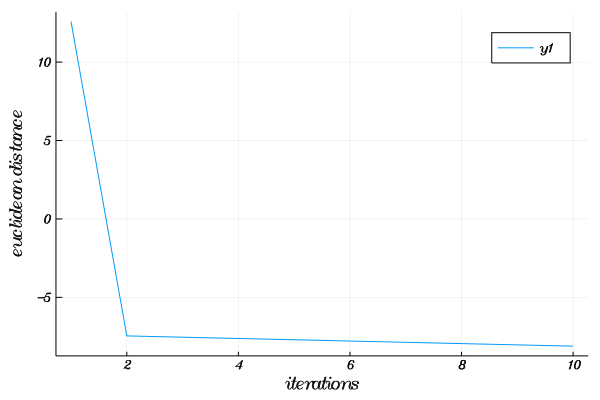

In [491]:
#using Pkg
#Pkg.add("Distances") #if you don't have it
#using Distances

V1 = V_sums[2:cnt-1,:]
V2 = V_sums[3:cnt,:]
distances = [euclidean(V1[i,:],V2[i,:]) for i in 1:cnt-2]

displot = plot(log.(distances))
xlabel!(displot,"iterations")
ylabel!(displot,"euclidean distance")

I decided to use Euclidean distance to plot successive errors. The y axis in the above plot is in log scale. Another way to do it is to take the convergence value as reference and plot the distance to that final value (see below).

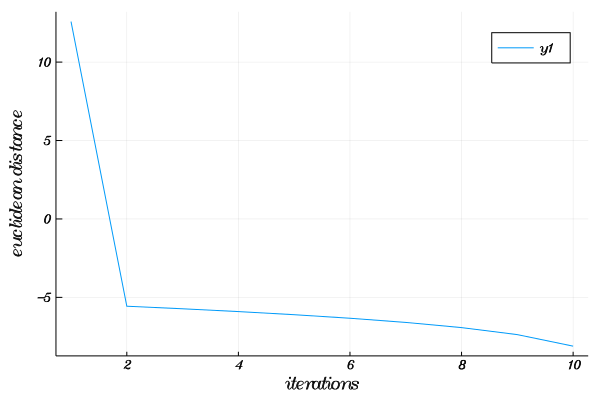

In [493]:
# plot of error with relation to final value
ref = V2[end,:]
distances = [euclidean(V1[i,:],ref) for i in 1:cnt-2]

displot2 = plot(log.(distances))
xlabel!(displot2,"iterations")
ylabel!(displot2,"euclidean distance")


## Neoclassical growth model (2)

We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$.

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

Since the problem is time homogenous, the value function depends on available capital only and satisfies the following Bellman equation:

$$V\left(\underbrace{k}_{k_t}\right) = \max_{c\in[0,1[} U(c) + \beta V\left(\underbrace{(1-\delta)k + \underbrace{(k^{\alpha}-c)}_{y_{t+1}}}_{k_{t+1}}\right)$$

Our goal is to obtain a smooth approximation of $k$ and $V$ by using interpolations techniques.

For this model, using the dynamic first-order conditions, one can show the deterministic steady-state of the model satisfies $1=\beta \left( (1-\delta) + \alpha k^{\alpha -1} \right)$. 

__Create a suitable Parameter type to hold the parameters. Write a function `steady_state(p::Parameter)` to compute the steady-state capital `kbar` and the corresponding steady-state consumption `cbar`__ 


In [280]:
struct Param
    alpha::Float64
    beta::Float64
    gamma::Float64
    delta::Float64
end

In [281]:
function steady_state(p::Param)
    kbar = ((1/p.beta + p.delta - 1)/p.alpha)^(1/(p.alpha-1)) # obtained from the deterministic steady state condition
    cbar = kbar^p.alpha - p.delta*kbar #obtained from k_t+1 = (1-delta)k_t - i_t
    return kbar, cbar
end

steady_state (generic function with 1 method)

__Set $N=10$ and define a reasonable grid `kgrid=range(kmin, kmax; length=N)` to approximate capital $k$.__


In [322]:
N = 10
p = Param(0.3, 0.96, 4., 0.059) 
kbar, cbar = steady_state(p)

# we need kmin < kbar < kmax
kmin = (1 - 0.3) * kbar;
kmax = (1 + 0.3) * kbar;

kgrid=range(kmin, kmax; length = N);

__The unknown value function is represented as a `N` elements arrays. Define `Vi(k,p)=U(δ * k^α)/(1-𝛽)` and compute the initial guess `V0 = [Vi(k,p) for k in kgrid]`. Define a finer grid `ktest=range(kmin, kmax;length=1000)` and find the values of `Vi` on it by  using `Interpolations.jl` library to interpolate `V0` between the points of `kgrid`.__


In [323]:
#using Pkg
#Pkg.add("Interpolations")
using Interpolations

In [324]:
Vi(k,p) = (p.delta * k^p.alpha)^(1-p.gamma)/((1-p.beta)*(1-p.gamma))
V0 = [Vi(k,p) for k in kgrid];

ktest=range(kmin, kmax; length = 500);
V0test = [Vi(k,p) for k in ktest];

#interpolation 
# itp = interpolate(V0, BSpline(Quadratic(Line(OnGrid()))));
itp = interpolate(V0, BSpline(Linear()))
sitp = scale(itp, kgrid);


__Compute a Bellman improvement function `bellman(V0::Vector{Float64}, p::Parameter, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}` which does the following steps:__

- take an initial guess `V0` for the value function

- at each grid point from kgrid, optimize nonlinearly, the function $c \rightarrow U(c) + \beta V\left((1-\delta)k + (k^{\alpha}-c)\right)$ for each capital level in the grid `kgrid`. In this expression the function `V()` interpolates `V0` defined on `kvec` on any point `k` so that the resulting function is continuous. 

- return the updated value and investment rules

In [325]:
# DEBUGGING

# V0 = [1., 2., 3., 4. ];

#itp = interpolate(V0, BSpline(Linear()))
#sitp = scale(itp, kgrid)
#esitp = extrapolate(sitp,Line());

#for k in kgrid
#    println(k)
#end

In [326]:
function bellman(V0::Vector{Float64}, p::Param, kgrid)
    V = deepcopy(V0)
    C = zeros(length(V0))
    for (n,k) in enumerate(kgrid)
        nn0 = -1
        gv = -Inf
        copt = - 1.0
        for (nn,kk) in enumerate(kgrid)
            y = k^p.alpha
            i = kk - (1 - p.delta) * k # it works when I put 2 kk but that doesn't make sense, I think it should be kk - (1 - p.delta) * k 
            c = y - i
            
            if c < 0 # can't have negative consumption ! 
                continue
            end
            
            # new trial
            # itp = interpolate(V0, BSpline(Quadratic(Line(OnGrid()))));
            # sitp = scale(itp, kgrid);
            
            itp = interpolate(V0, BSpline(Linear()))
            sitp = scale(itp, kgrid)
            esitp = extrapolate(sitp,Line());
            
            foo = (1-p.delta) * kk + kk^p.alpha - c
            v = c^(1-p.gamma)/(1-p.gamma) + p.beta * esitp(foo)
            
            # v = c^(1-p.gamma)/(1-p.gamma) + p.beta * V0[nn] # this is also wrong 
            if v > gv
                gv = v
                copt = c
                nn0 = nn
            end
        end
        V[n] = gv
        C[n] = copt
    end
    return V, C
end

bellman (generic function with 3 methods)


__Write a value interation function `vfi(N, p)` which solves the model defined by parameter `p` using the value function algorithm. The function should return the value function and the policy rule.__


In [328]:
function vfi(V0, p, tol, kgrid)
    V0 = deepcopy(V0)
    V,C = bellman(V0, p, kgrid)
    
    while distance(V,V0) > tol
        V0 = V
        V, C = bellman(V, p, kgrid)
    end
    return V, C
end

vfi (generic function with 1 method)

__Plot the solution. Comment.__

In [329]:
tol = 0.001
V, C = vfi(V0 ,p, tol, kgrid)

([-4.1679393845468296, -4.029381902286395, -3.905788362138705, -3.7889930644072236, -3.683128041845909, -3.5801265811285465, -3.4852523374730646, -3.4033826044723714, -3.3325388011522663, -3.2712324286960666], [0.9209696718739515, 0.9419479718661508, 0.9605782118283397, 0.9771716230493035, 0.9919786217423621, 1.3224441339126258, 1.3342577428145954, 1.3448021692487926, 1.3541984046187872, 1.3625500888328912])

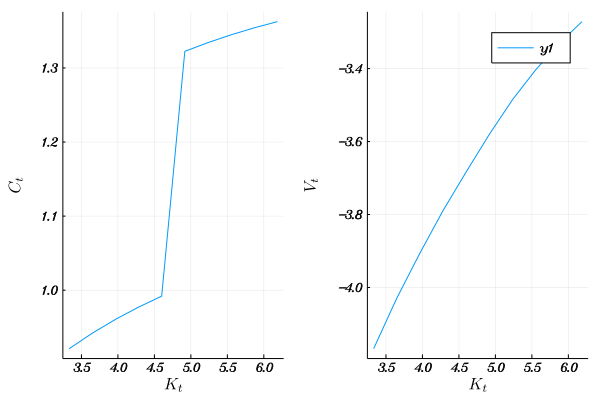

In [330]:
pl_v = plot(kgrid, V)
xlabel!(pl_v,"\$K_t\$")
ylabel!(pl_v,"\$V_t\$")

pl = plot(kgrid, C, label="")
xlabel!(pl,"\$K_t\$")
ylabel!(pl,"\$C_{t}\$") # i'm actually plotting investment (wtf)

plot(pl, pl_v)

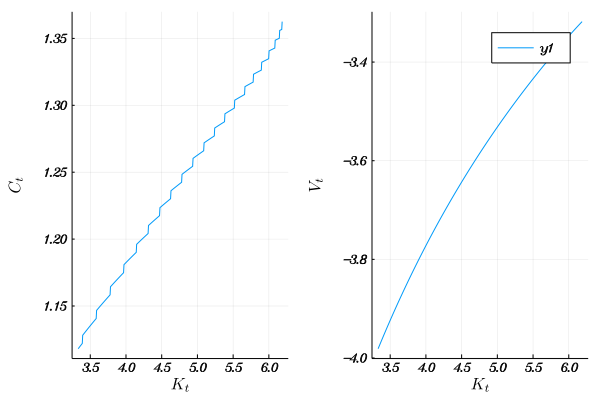

In [331]:
tol = 0.001
V, C = vfi(V0test, p, tol, ktest)

pl_v = plot(ktest, V)
xlabel!(pl_v,"\$K_t\$")
ylabel!(pl_v,"\$V_t\$")

pl = plot(ktest, C, label="")
xlabel!(pl,"\$K_t\$")
ylabel!(pl,"\$C_{t}\$") # i'm actually plotting investment (wtf)

plot(pl, pl_v)

It seems consistent. The more capital you have, the more consumption you can afford. 

__Bonus 1: plot a graph showing the convergence back to the steady-state__


__Bonus 2: implement the policy iteration algorithm by adding an evaluation step in the `vfi` function.__
